In [43]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import matplotlib

from tensorflow.keras.utils import to_categorical
from google.colab import files
from keras import layers
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

%config InlineBackend.figure_format = 'retina'

In [45]:
def load_data(train_path, test_path):
  with open(train_path, mode='rb') as f:
    train = pickle.load(f)
  
  with open(test_path, mode='rb') as f:
    test = pickle.load(f)
      
  print("Data loaded")

  return train, test

In [46]:
training_file = "/content/drive/MyDrive/Colab Notebooks/DicodingMLTerapan/Datasets/GermanTrafficSign/train.p"
testing_file = "/content/drive/MyDrive/Colab Notebooks/DicodingMLTerapan/Datasets/GermanTrafficSign/test.p" 

train, test = load_data(training_file, testing_file)

Data loaded


In [47]:
signs_name_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DicodingMLTerapan/Datasets/GermanTrafficSign/signnames.csv')
signs_name_df.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [48]:
sign_name = signs_name_df.SignName.values
sign_name

array(['Speed limit (20km/h)', 'Speed limit (30km/h)',
       'Speed limit (50km/h)', 'Speed limit (60km/h)',
       'Speed limit (70km/h)', 'Speed limit (80km/h)',
       'End of speed limit (80km/h)', 'Speed limit (100km/h)',
       'Speed limit (120km/h)', 'No passing',
       'No passing for vechiles over 3.5 metric tons',
       'Right-of-way at the next intersection', 'Priority road', 'Yield',
       'Stop', 'No vechiles', 'Vechiles over 3.5 metric tons prohibited',
       'No entry', 'General caution', 'Dangerous curve to the left',
       'Dangerous curve to the right', 'Double curve', 'Bumpy road',
       'Slippery road', 'Road narrows on the right', 'Road work',
       'Traffic signals', 'Pedestrians', 'Children crossing',
       'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing',
       'End of all speed and passing limits', 'Turn right ahead',
       'Turn left ahead', 'Ahead only', 'Go straight or right',
       'Go straight or left', 'Keep right', 'Keep le

In [49]:
X, y = train['features'], train['labels']

data = np.array(X)
labels = np.array(y)

print(data.shape, labels.shape)

X_test, y_test = test['features'], test['labels']

X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [50]:
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=.1, random_state=0)

print(X_train.shape, X_val.shape, X_test.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (12630, 32, 32, 3)


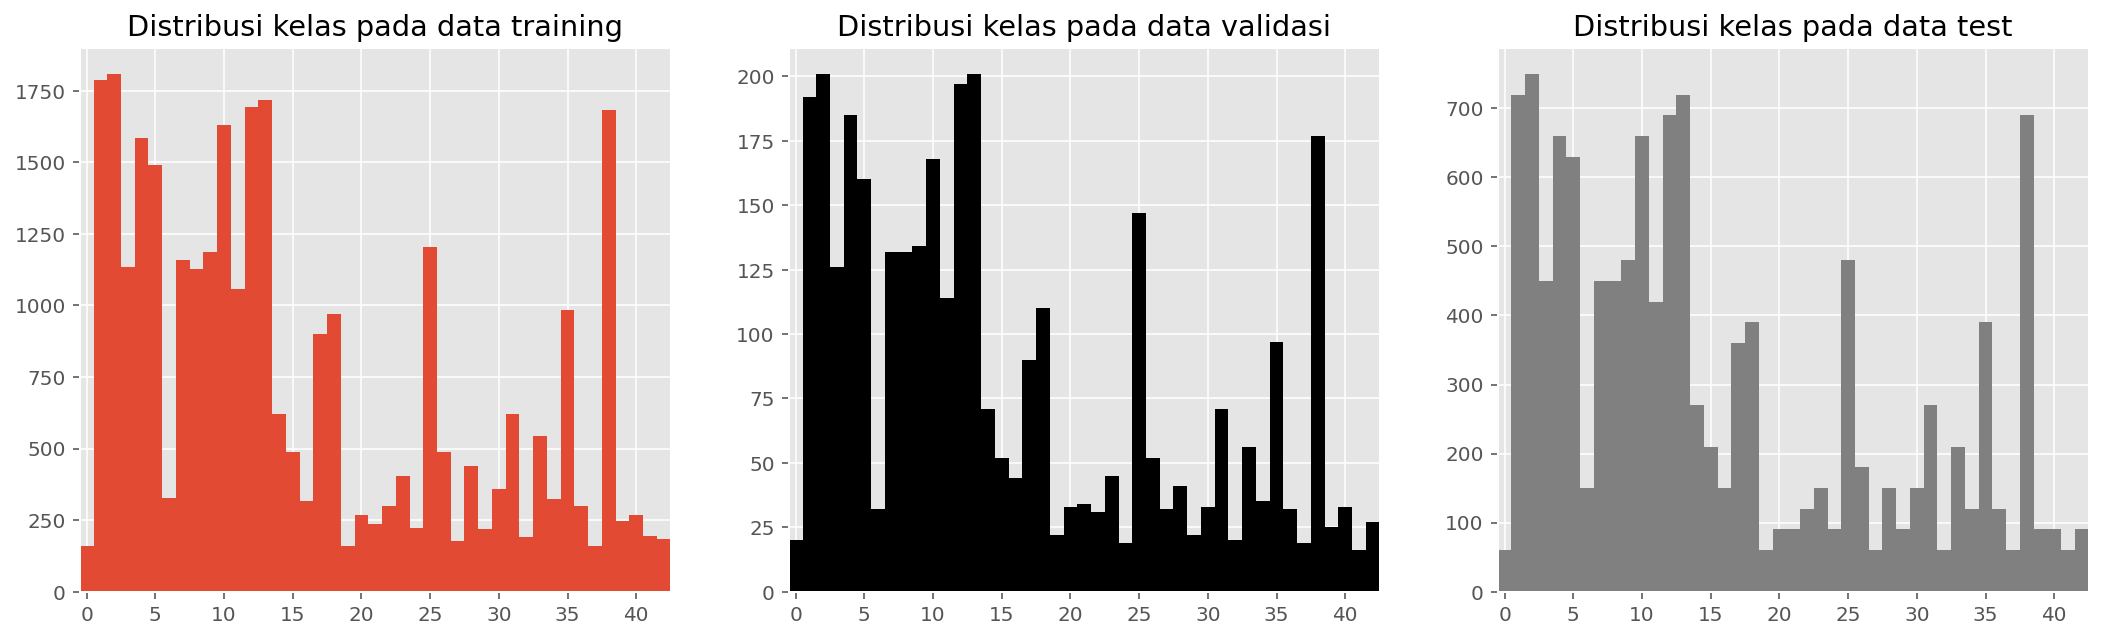

In [51]:
n_labels = np.unique(y_train).size

def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)
        
fig, ax = plt.subplots(1,3, figsize=(18,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [52]:
y_train = to_categorical(y_train, n_labels)
y_val = to_categorical(y_val, n_labels)

In [61]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs['acc'] >= 0.96):
      print('\nAkurasi telah mencapai 96%, Stop training!')
      self.model.stop_training = True

callback = MyCallback()

In [62]:
def build_model(n_classes):
  model = Sequential()
  # CNN layer 1
  model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=X_train.shape[1:]))
  model.add(layers.Conv2D(32, (5, 5), activation='relu'))
  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Dropout(0.25))
  # CNN layer 2
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Dropout(0.25))
  ## Fully Connected layer
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(n_classes, activation='softmax'))

  model.summary()

  return model

In [63]:
epoch = 25

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()

model = build_model(n_labels)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['acc'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 conv2d_36 (Conv2D)          (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 12, 12, 32)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 conv2d_38 (Conv2D)          (None, 8, 8, 64)          36928     
                                                     

In [64]:
hist = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=epoch,
    validation_data=(X_val, y_val),
    callbacks=[callback],
    verbose=1
  )

Epoch 1/25
979/979 [==============================] - 9s 8ms/step - loss: 1.6119 - acc: 0.5864 - val_loss: 0.2257 - val_acc: 0.9399
Epoch 2/25
979/979 [==============================] - 5s 5ms/step - loss: 0.4288 - acc: 0.8747 - val_loss: 0.1565 - val_acc: 0.9701
Epoch 3/25
979/979 [==============================] - 5s 5ms/step - loss: 0.2922 - acc: 0.9171 - val_loss: 0.0852 - val_acc: 0.9773
Epoch 4/25
979/979 [==============================] - 5s 5ms/step - loss: 0.2565 - acc: 0.9285 - val_loss: 0.1041 - val_acc: 0.9716
Epoch 5/25
979/979 [==============================] - 5s 5ms/step - loss: 0.2390 - acc: 0.9340 - val_loss: 0.0852 - val_acc: 0.9767
Epoch 6/25
979/979 [==============================] - 5s 5ms/step - loss: 0.2101 - acc: 0.9430 - val_loss: 0.0483 - val_acc: 0.9899
Epoch 7/25
979/979 [==============================] - 5s 5ms/step - loss: 0.2155 - acc: 0.9421 - val_loss: 0.0822 - val_acc: 0.9787
Epoch 8/25
979/979 [==============================] - 5s 5ms/step - loss: 0.

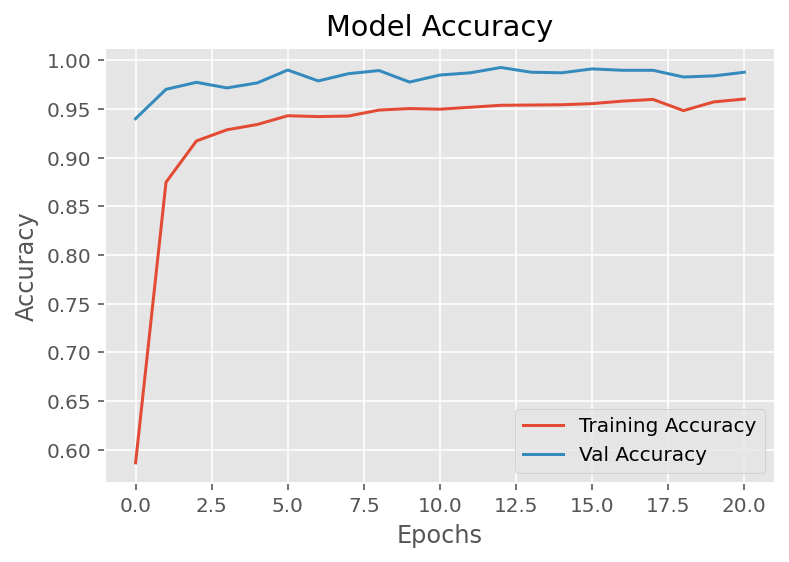

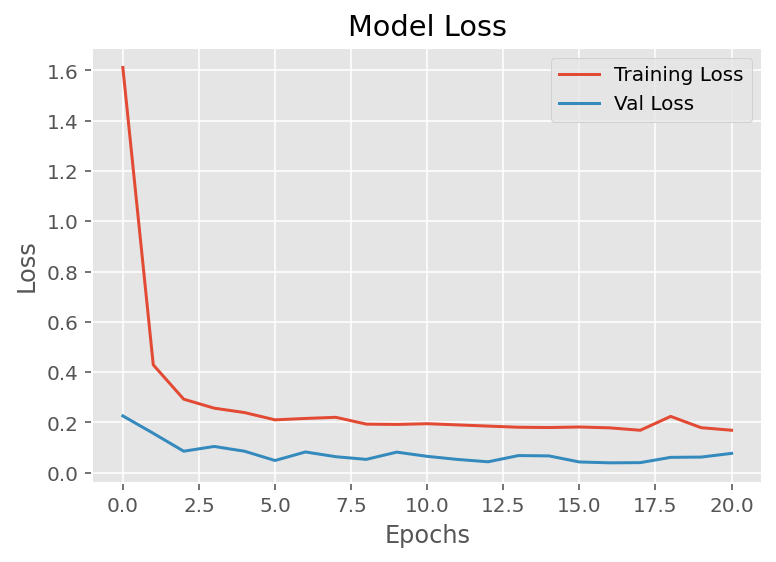

In [65]:
# Plot graph for accuracy
plt.plot(hist.history['acc'], label='Training Accuracy')
plt.plot(hist.history['val_acc'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot graph for loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [72]:
pred = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

0.9419635787806809

In [74]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.63      0.78        60
           1       0.94      0.95      0.95       720
           2       0.89      0.99      0.93       750
           3       0.97      0.96      0.96       450
           4       0.93      0.99      0.96       660
           5       0.90      0.91      0.90       630
           6       0.98      0.75      0.85       150
           7       0.96      0.94      0.95       450
           8       0.90      0.97      0.93       450
           9       0.91      1.00      0.95       480
          10       0.97      0.99      0.98       660
          11       0.97      0.94      0.96       420
          12       0.99      0.98      0.98       690
          13       0.97      0.99      0.98       720
          14       0.98      0.98      0.98       270
          15       0.93      0.90      0.92       210
          16       0.97      0.99      0.98       150
          17       0.99    